<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Treinamento_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotinas de Treinamento


## Configurações Iniciais 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
py.init_notebook_mode(connected=True)
%matplotlib inline
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

## Lendo a Base

In [57]:
# Base1 Com StopWords
PATH_BASE1 = "/content/drive/MyDrive/TCC/dados/processadas/Base1_classificada.csv"

# Base2 Sem StopWords
PATH_BASE2 = "/content/drive/MyDrive/TCC/dados/processadas/Base2_classificada.csv"

# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA = "/content/drive/MyDrive/TCC/dados/processadas/Base1JuntaHateENotHateDaLeila.csv"

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA = "/content/drive/MyDrive/TCC/dados/processadas/Base2_maior4_menor25_limpissima.csv"

In [58]:
#trainDF = pd.read_csv(PATH_BASE2_LEILA_LIMPISSIMA, index_col=0)
trainDF = pd.read_csv(PATH_BASE2_LEILA_LIMPISSIMA)

In [59]:
# Agrupa dados por label
trainDF.groupby('label').count()

,text
label,
hate,2443
not_hate,19282


In [60]:
categorias_desejadas = ['hate', 'not_hate'] # !!!
df_filtrado = trainDF[trainDF.label.isin(categorias_desejadas)]
df_filtrado.shape

(21725, 2)

In [62]:
df_filtrado

,label,text
0,not_hate,geral foi no jogo do foz
1,not_hate,pois é não é gente é isso ai pessoal
2,not_hate,ontem eu estava tão mal que escrevi tudo o que...
3,not_hate,eu devo ter um coração de pedra não sou de me ...
4,not_hate,camimq vivobr pois é estou tentando entender
...,...,...
21720,hate,eduguim depois falam que nordestino não sabe ...
21721,hate,e dizem por aí que o nordestino não sabe votar
21722,hate,ain que nordestino não sabe votar e blá blá blá
21723,hate,imagine essa turma da extrema direita soltando...


In [63]:
def balanceia_dados(df, verbose=0):
    # Esta funcao recebe um dataframe original e retorna um dataset
    # contendo um numero igual de noticias das categorias
    # por simplicidade, vou supor que são somente duas categorias.
    global categorias_desejadas
    df_balanceado = df.copy()
    
    # cria um dataframe para cada classe. Assim podemos remover o excesso
    df_F = df_balanceado.loc[df_balanceado.label == categorias_desejadas[0]]
    df_T = df_balanceado.loc[df_balanceado.label == categorias_desejadas[1]]

    num_amostras_F, num_amostras_T = df_F.shape[0], df_T.shape[0]
    num_amostras_a_remover = abs(num_amostras_F - num_amostras_T)
    
    # remove amostras da classe majoritaria
    if num_amostras_F > num_amostras_T:
        #print(df_F[:num_amostras_a_remover)
        df_F = df_F[num_amostras_a_remover:]
        
    elif num_amostras_T > num_amostras_F:
        #
        df_T = df_T[num_amostras_a_remover:]

    return pd.concat([df_F, df_T])

In [64]:
# Aplica função de balancear os dados
dataBC = balanceia_dados(df_filtrado)

# DATA BALANCEADO
trainDF = dataBC
trainDF.reset_index(drop=True, inplace=True) # reseta index
trainDF.shape

(4886, 2)

In [65]:
trainDF.to_csv("base2_sem_stopword_balanceada.csv")

In [66]:
# convert output  hate =1 not_hate =0
trainDF.label = [1 if each == "hate" else 0 for each in trainDF.label] 

In [67]:
trainDF.groupby('label').count()

,text
label,
0,2443
1,2443


In [68]:
# Pega a média de caracteres dos tweets de toda a base
average_len = int(trainDF['text'].apply(lambda x: len(str(x))).mean())
average_len

62

In [69]:
quantidade_palavras_unicas = len( list ( trainDF['text'].str.split(' ', expand=True).stack().unique() ) )
quantidade_palavras_unicas

9144

## Naive Bayes

In [70]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [71]:
accuracy = []
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.3, random_state=2)
encoder = preprocessing.LabelEncoder() # !!!
train_y_enc = encoder.fit_transform(train_y)
valid_y_enc = encoder.fit_transform(valid_y)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

# Naive Bayes on Count Vectors
accuracy.append( train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y_enc, xvalid_count))
print ("NB, Count Vectors: ", accuracy)

NB, Count Vectors:  [0.9304229195088677]


In [72]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features= quantidade_palavras_unicas)
X = tfidf_vect.fit_transform(trainDF['text'])

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X, trainDF['label'], test_size=0.3, random_state=2)

# Naive Bayes on Word Level TF IDF Vectors
accuracy.append(train_model(naive_bayes.MultinomialNB(), train_x, train_y, valid_x))
print ("NB, WordLevel TF-IDF: ", accuracy)

NB, WordLevel TF-IDF:  [0.9304229195088677, 0.9181446111869032]


In [73]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=quantidade_palavras_unicas)
X = tfidf_vect_ngram.fit_transform(trainDF['text'])

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X, trainDF['label'], test_size=0.3, random_state=2)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy.append(train_model(naive_bayes.MultinomialNB(), train_x, train_y, valid_x))
print ("NB, N-Gram(1,2) Vectors: ", accuracy)

NB, N-Gram(1,2) Vectors:  [0.9304229195088677, 0.9181446111869032, 0.9181446111869032]


In [74]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=quantidade_palavras_unicas)
X = tfidf_vect_ngram.fit_transform(trainDF['text'])

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X, trainDF['label'], test_size=0.3, random_state=2)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy.append(train_model(naive_bayes.MultinomialNB(), train_x, train_y, valid_x))
print ("NB, N-Gram(2,3) Vectors: ", accuracy)

NB, N-Gram(2,3) Vectors:  [0.9304229195088677, 0.9181446111869032, 0.9181446111869032, 0.8697135061391542]


In [75]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=quantidade_palavras_unicas)
X = tfidf_vect_ngram_chars.fit_transform(trainDF['text']) 

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X, trainDF['label'], test_size=0.3, random_state=2)

# Naive Bayes on Character Level TF IDF Vectors
accuracy.append(train_model(naive_bayes.MultinomialNB(), train_x, train_y, valid_x))
print ("NB, N-Gram(2,3) CharLevel Vectors: ", accuracy)

NB, N-Gram(2,3) CharLevel Vectors:  [0.9304229195088677, 0.9181446111869032, 0.9181446111869032, 0.8697135061391542, 0.8649386084583902]


No handles with labels found to put in legend.


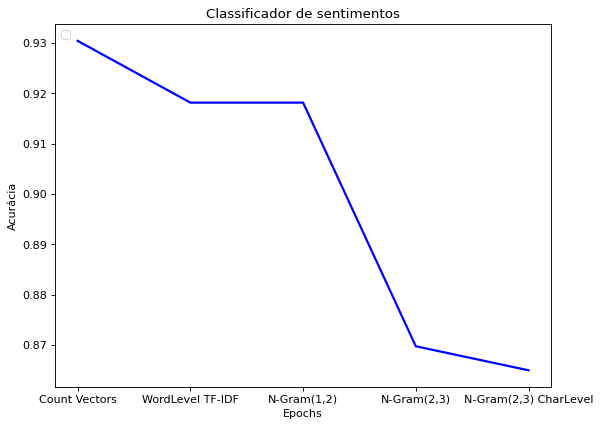

In [76]:
#  # Plot
# plt.figure()
# plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
# plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
# plt.title('Classificador de sentimentos')
# plt.xlabel('Epochs')
# plt.ylabel('Cross-Entropy')
# plt.legend(loc='upper right')
# plt.show()
y = ['Count Vectors','WordLevel TF-IDF','N-Gram(1,2)','N-Gram(2,3)','N-Gram(2,3) CharLevel']
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(y,accuracy, lw=2.0, color='b')
#plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('Classificador de sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()